## Questão 1 — single linkage

No **single linkage**, a distância entre dois clusters é a **menor distância** entre quaisquer dois pontos, um de cada cluster:


\[ d_{single}(A, B) = \min_{x \in A,\; y \in B} d(x,y) \].

Consequência: se existir **um par de pontos muito próximos** em clusters diferentes, o algoritmo considera esses clusters **próximos** e tende a **fundi-los**, mesmo que o restante esteja mais espalhado. Isso gera o **efeito-cadeia** (*chaining*), no qual uma sequência de pares próximos pode **colar** dois agrupamentos que visualmente parecem separados. Também é comum sobrar **ponto isolado** quando cortamos a hierarquia fixando \(K\).


![Questão 2](./imagens/Figura1.png)


## Questão 2 — single linkage ilustrada

A sequência de fusões usada na demonstração está no arquivo de imagem abaixo (use o caminho relativo do seu projeto).

![Questão 2](./imagens/Sequencia_Questao2.png)


Podendo resultar em algo deste tipo :


![Questão 2](./imagens/linked_1_resultado_possivel.png)

## Questão 3 - Ward Linkage

O Ward a cada passo realizado avalia  o **par de clusters cuja fusão realiza o menor aumenta a soma dos erros internos** (WCSS = soma dos quadrados das distâncias dos pontos ao centróide do seu cluster).
Para dois clusters $A$ e $B$, o “custo” de fundir é:

$$
\Delta(A,B)=\frac{n_A\,n_B}{n_A+n_B}\,\|\mu_A-\mu_B\|^2
$$

($n$=tamanho; $\mu$=centróide). Ward sempre funde o par com **menor $\Delta$**. Isso favorece **grupos compactos** e desencoraja “pontes” (evita o *chaining* do single).

## Questão 4 - Ward Linkage Ilustrado 


![Questão 4](./imagens/Ward.png)




## Questão 5 - Complete linkage

**Ideia central.**
No *complete linkage* (ligação completa), a distância entre dois clusters $A$ e $B$ é a **maior distância** entre quaisquer dois pontos, um de cada cluster:

$$
d_{\text{complete}}(A,B)=\max_{x\in A,\,y\in B} d(x,y).
$$

Ou seja, dois clusters só são “próximos” se **todos** os pares entre eles forem razoavelmente próximos. Isso **desencoraja fusões** que produzam grupos alongados/espalhados e reduz o *chaining* visto no single linkage.

## Questão 6 - Complete linkage Ilustrado  


![Questão 6](./imagens/linked_1_completepng.png)


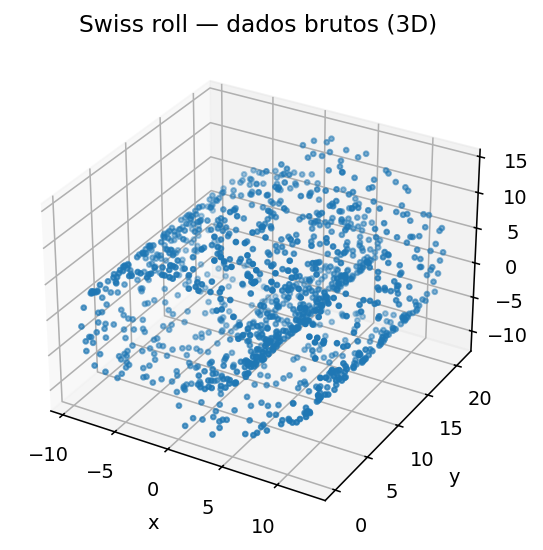

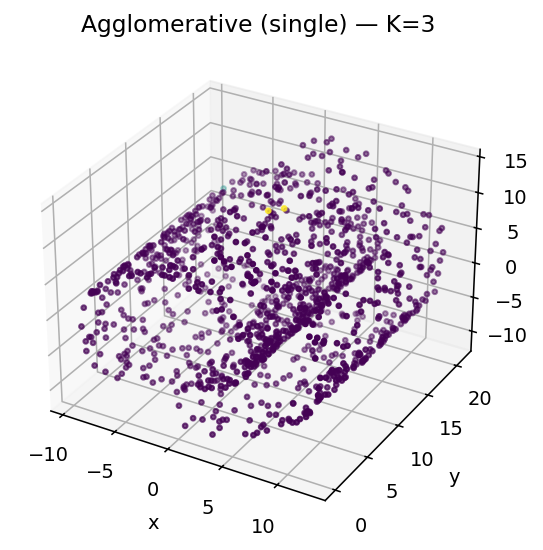

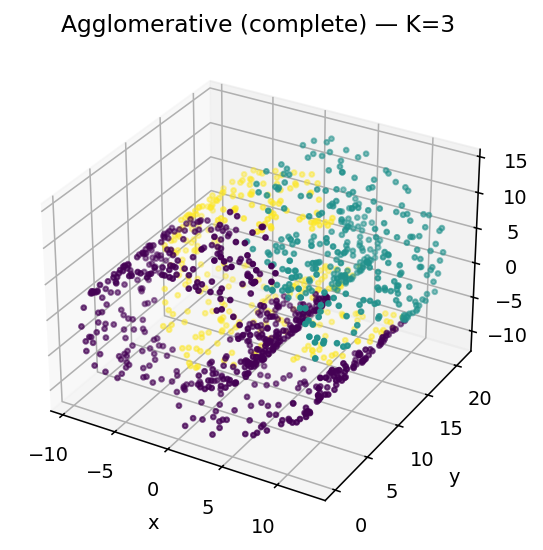

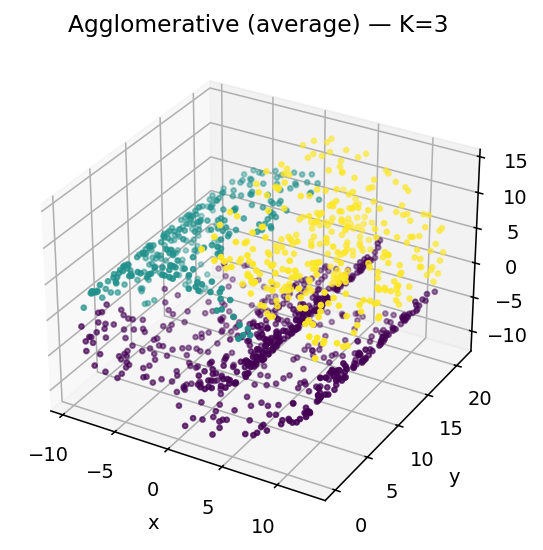

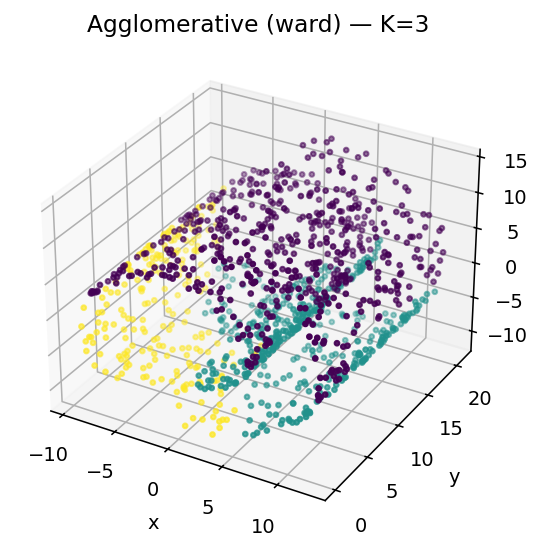

    linkage  silhouette  calinski_harabasz  davies_bouldin
2   average      0.2513           425.7565          1.2896
3      ward      0.2445           426.3425          1.3424
1  complete      0.1777           309.9733          1.6284
0    single     -0.0847             2.3275          0.8128


In [19]:
# -*- coding: utf-8 -*-
# Clusterização hierárquica no Swiss Roll (make_swiss_roll)
# Corrigido para funcionar em qualquer versão do scikit-learn:
# - usa 'metric="euclidean"' (novas versões)
# - faz fallback para 'affinity="euclidean"' (versões antigas)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necessário para 3D)
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# ------------------------------------------------------------
# 1) Dados (Swiss Roll)
# ------------------------------------------------------------
N = 1200
X, t = make_swiss_roll(n_samples=N, noise=0.05, random_state=42)

fig = plt.figure(figsize=(6, 4), dpi=140)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=6)   # sem definir cores manualmente
ax.set_title("Swiss roll — dados brutos (3D)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 2) Função compatível para criar modelo (metric/affinity)
# ------------------------------------------------------------
def make_model(linkage: str, k: int) -> AgglomerativeClustering:
    if linkage == "ward":
        # Ward não aceita 'metric' diferente de euclidiana
        return AgglomerativeClustering(linkage="ward", n_clusters=k)
    # Tenta API nova (metric=...)
    try:
        return AgglomerativeClustering(linkage=linkage, metric="euclidean", n_clusters=k)
    except TypeError:
        # Fallback para API antiga (affinity=...)
        return AgglomerativeClustering(linkage=linkage, affinity="euclidean", n_clusters=k)

# ------------------------------------------------------------
# 3) Rodar hierárquico com 4 linkages e K=3
# ------------------------------------------------------------
K = 3
metricas = []

for linkage in ["single", "complete", "average", "ward"]:
    modelo = make_model(linkage, K)
    labels = modelo.fit_predict(X)

    # métricas
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    metricas.append({"linkage": linkage, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})

    # plot 3D
    fig = plt.figure(figsize=(6, 4), dpi=140)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=6)  # sem cmap explícito
    ax.set_title(f"Agglomerative ({linkage}) — K={K}")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 4) Tabela de resultados
# ------------------------------------------------------------
df = pd.DataFrame(metricas).sort_values("silhouette", ascending=False)
print(df.round(4))


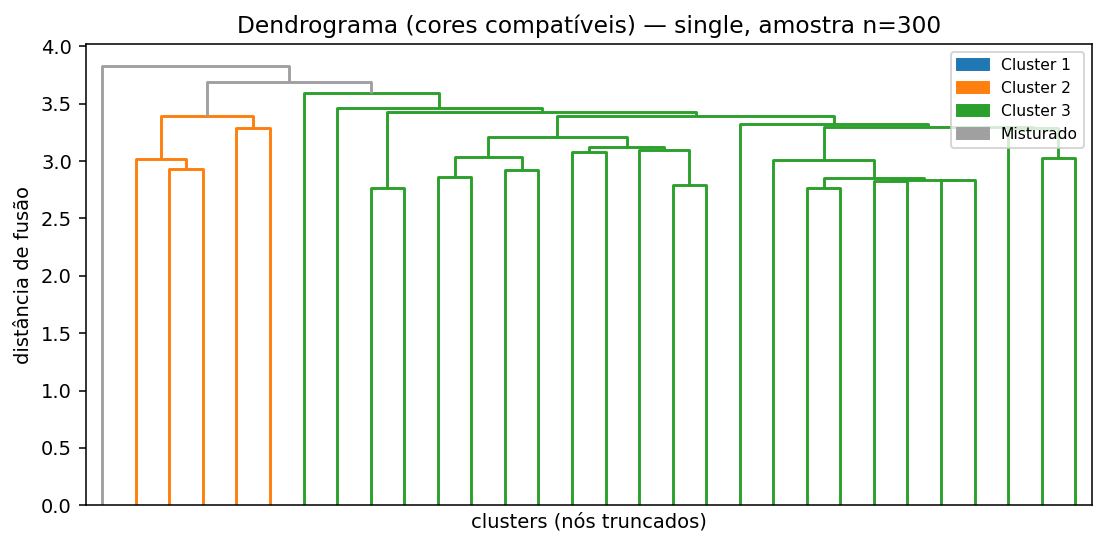

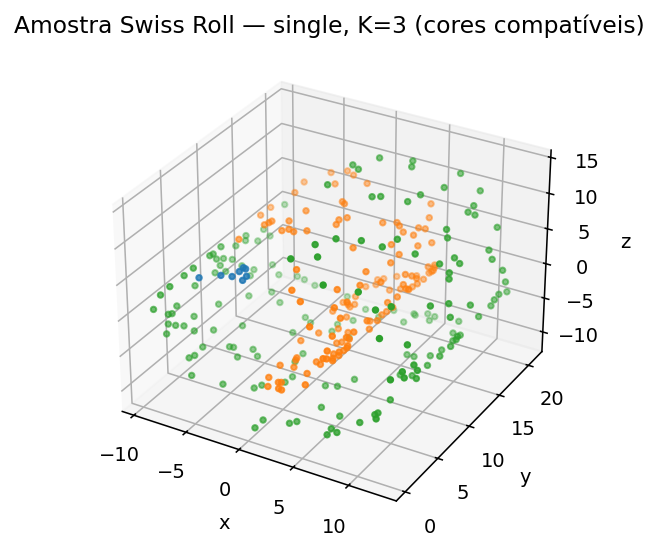

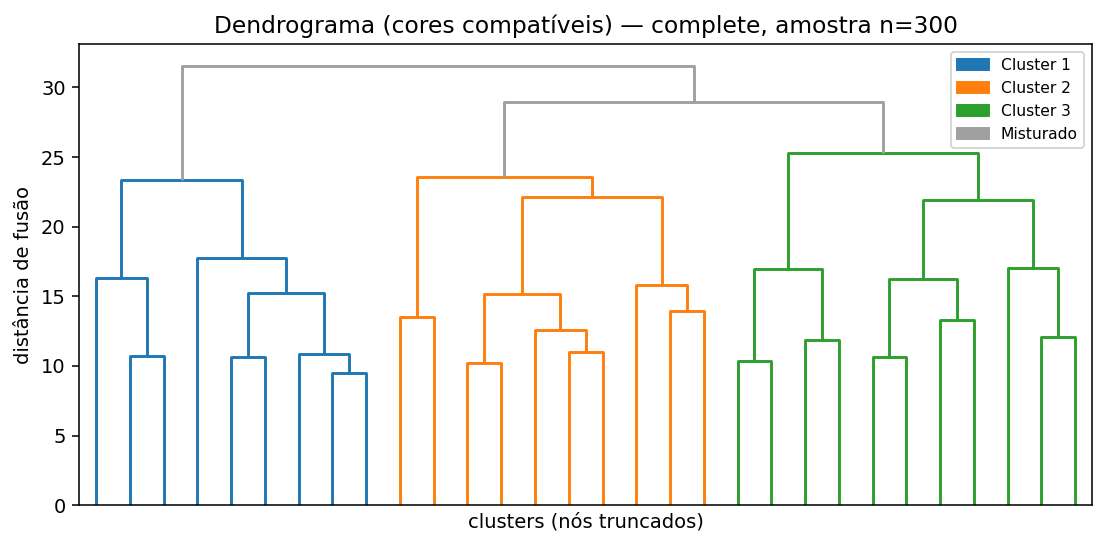

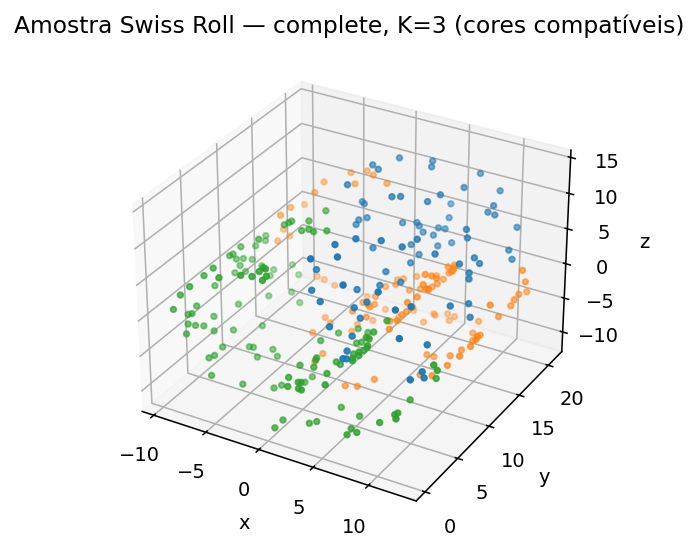

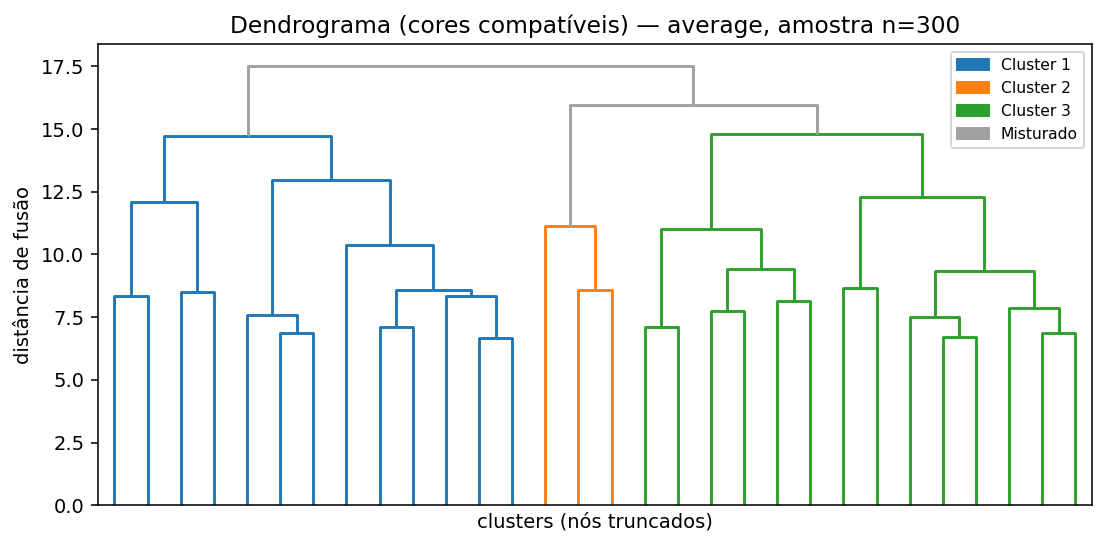

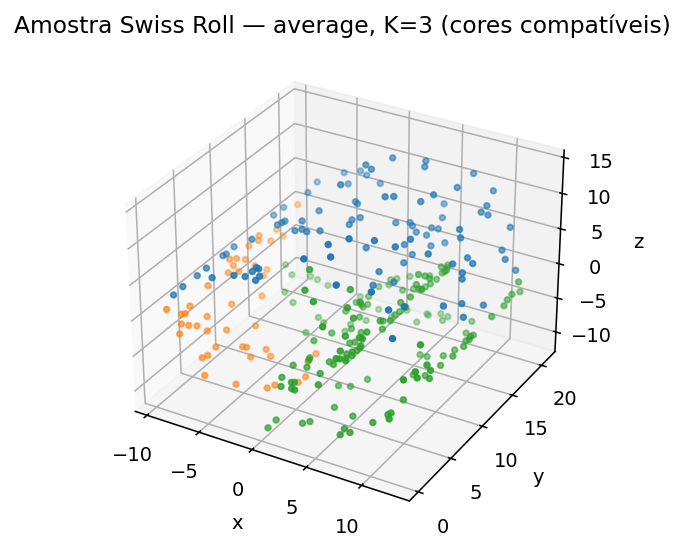

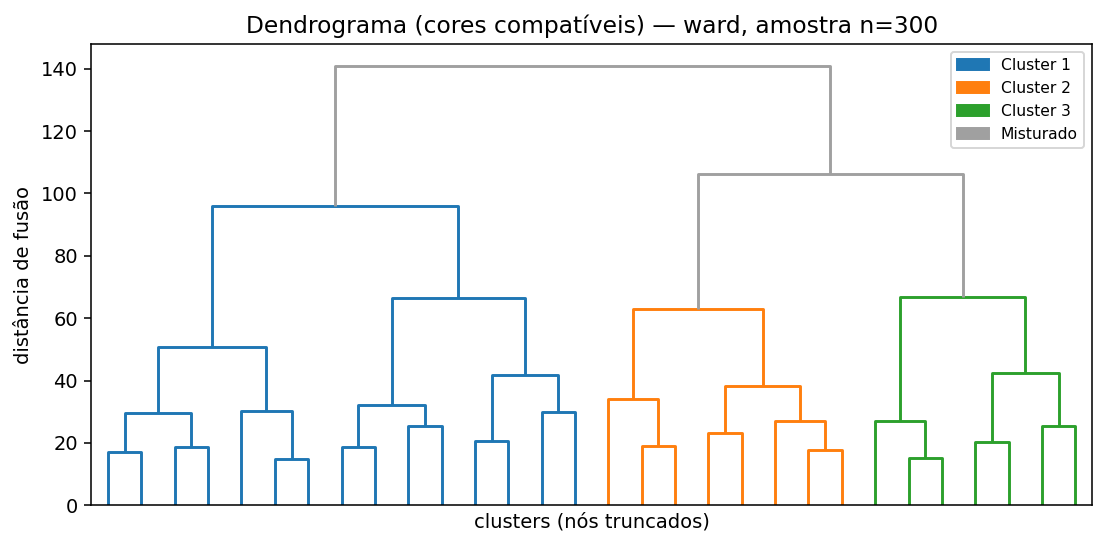

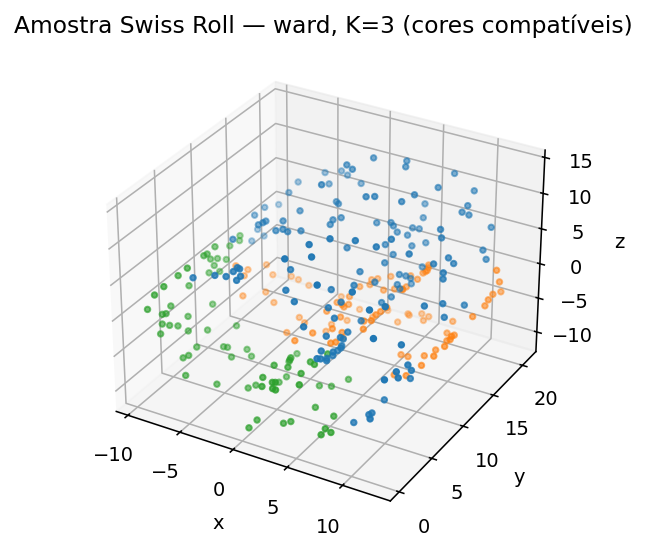

In [28]:
# Questão 8 - Dendrogramas

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_swiss_roll
from matplotlib.colors import to_hex

# Dados (Swiss roll) e amostra
N = 1200
X, t = make_swiss_roll(n_samples=N, noise=0.05, random_state=42)
rng = np.random.RandomState(42)
m = min(300, len(X))
idx = rng.choice(len(X), size=m, replace=False)
Xs = X[idx]

def make_link_color_func(Z, labels_1based, label_to_color_hex, mixed_color="#808080"):
    n = Z.shape[0] + 1
    children = {i+n: (int(Z[i,0]), int(Z[i,1])) for i in range(Z.shape[0])}
    memo = {}
    def leaves_of(node):
        if node in memo: return memo[node]
        if node < n:
            memo[node] = [node]
        else:
            a, b = children[node]
            memo[node] = leaves_of(a) + leaves_of(b)
        return memo[node]
    def color_func(k):
        L = leaves_of(int(k))
        labs = labels_1based[np.array(L, dtype=int)]
        if np.all(labs == labs[0]):
            return label_to_color_hex[int(labs[0])]
        else:
            return mixed_color
    return color_func

K = 3
methods = ["single", "complete", "average", "ward"]
tab = plt.get_cmap("tab10").colors
palette_hex = [to_hex(tab[i]) for i in range(K)]  # hex strings

for method in methods:
    Z = linkage(Xs, method=method)
    labels = fcluster(Z, t=K, criterion="maxclust")
    label_to_color_hex = {k+1: palette_hex[k] for k in range(K)}

    # Dendrograma
    plt.figure(figsize=(8, 4), dpi=140)
    link_cf = make_link_color_func(Z, labels, label_to_color_hex, mixed_color="#A0A0A0")
    dendrogram(
        Z,
        truncate_mode="lastp", p=30, no_labels=True,
        color_threshold=0.0,
        link_color_func=link_cf
    )
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=palette_hex[k], label=f"Cluster {k+1}") for k in range(K)]
    patches.append(mpatches.Patch(color="#A0A0A0", label="Misturado"))
    plt.legend(handles=patches, loc="upper right", fontsize=8, frameon=True)
    plt.title(f"Dendrograma (cores compatíveis) — {method}, amostra n={len(Xs)}")
    plt.xlabel("clusters (nós truncados)"); plt.ylabel("distância de fusão")
    plt.tight_layout(); plt.show()

    # Scatter 3D compatível
    colors_pts = [label_to_color_hex[int(l)] for l in labels]
    fig = plt.figure(figsize=(6, 4), dpi=140)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xs[:, 0], Xs[:, 1], Xs[:, 2], c=colors_pts, s=8)
    ax.set_title(f"Amostra Swiss Roll — {method}, K={K} (cores compatíveis)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    plt.tight_layout(); plt.show()


# Questão 10 e 11

## Leitura por método
- **Single linkage**: forte **efeito-cadeia**. O dendrograma tem vários ramos em alturas parecidas e muitos nós **misturados** (cores cinza). No heatmap, os blocos são pouco nítidos, com várias distâncias baixas **entre** clusters. Interpretação: o algoritmo vai “costurando” a superfície do rolo via pares próximos, formando componentes alongadas e pouco estáveis.
- **Complete linkage**: clusters **mais compactos**. O dendrograma mostra fusões finais em alturas maiores; o heatmap fica mais **bloco-diagonal**. Tende a “quebrar” estruturas muito alongadas em partes mais coesas — no Swiss Roll, isso aparece como **fatias** da folha.
- **Average linkage**: comportamento intermediário; blocos razoavelmente definidos e menos sensível a cadeias do que o single.
- **Ward**: blocos mais **limpos** no heatmap e **grande salto** nas últimas fusões. Melhor separação em termos de variância intra-cluster (como indicado também pelas métricas calculadas anteriormente). Porém, por otimizar variância **euclidiana**, o Ward tende a **fatiar** o Swiss Roll em planos, não a seguir a geodesia da espiral.

## Significado dos agrupamentos (K = 3)
Os três grupos refletem **faixas da folha** do rolo (ex.: regiões “interna”, “média” e “externa”), e **não** classes naturais distintas. Em outras palavras, estamos particionando por **posição no espaço euclidiano** — cortes tipo “fatias” do rolo — em vez de acompanhar o percurso da espiral. O single chega a conectar faixas via pontos-ponte; complete/average/ward evitam isso e produzem cortes mais nítidos, com destaque para o Ward.

## Conclusões práticas
1. Para dados com **manifold curvo** (como o Swiss Roll), métodos hierárquicos com distância **euclidiana** tendem a **fatiar** a estrutura. Os agrupamentos encontrados são coerentes geometricamente, mas **não** representam caminhos geodésicos.
2. **Ward** e **average/complete** entregam separações mais limpas que **single** (menos cadeias). Ward normalmente aparece com melhor *silhouette* e salto mais claro no dendrograma.
3. Se o objetivo é **seguir a espiral**, use distâncias/representações que respeitem a geometria:
   - Embed de **manifold learning** (Isomap/UMAP) e depois clusterização no espaço embutido;
   - Distância **geodésica** em grafo k-NN (e então hierárquico sobre essa métrica);
   - Algoritmos baseados em densidade (**DBSCAN/HDBSCAN**) com vizinhança apropriada para reduzir pontes.

**Resumo**: As figuras de Q8–Q9 confirmam que *single* sofre com cadeias; *complete* e *average* trazem blocos mais coesos; *ward* dá a partição mais compacta (mas ainda “em fatias”). A escolha do método deve refletir se você quer **compactação euclidiana** (ward/complete/average) ou **conectividade ao longo do manifold** (geodésica + clustering).

# Escolha de \(K\) por salto relativo e avaliação do resultado (Swiss Roll)

**Como decidir \(K\).** Considere as alturas de fusão do dendrograma \(h_0 \le \cdots \le h_{n-2}\). 
Compute os **saltos relativos** no topo da árvore \(r_i = h_{i+1}/h_i\). 
O **maior salto** indica onde a união de grupos passa a “custar caro”; o corte **antes** desse salto dá
\(K^{\ast} = n - (i^{\ast}+1)\).
Na prática, analisamos apenas os **últimos \(p\)** *merges* para evitar ruído das primeiras fusões.

**Aplicação ao Swiss Roll (dados da Q7).** Usando uma amostra do conjunto e avaliando os saltos relativos nos últimos níveis da árvore, obtivemos:

| Linkage   | \(K^{\ast}\) sugerido | Salto relativo (máx.) |
|-----------|----------------------:|----------------------:|
| Single    | 3                     | 1.096 |
| Complete  | 8                     | 1.136 |
| Average   | 7                     | 1.139 |
| Ward      | **3**                 | **1.451** |

**Leitura.** Em *Ward*, há um salto claro \(\Rightarrow\) **\(K=3\)** é bem suportado. Em *single*, o salto é fraco (efeito-cadeia) mas ainda aponta 3. *Complete* e *average* preferem mais **fatias** (7–8), pois penalizam clusters alongados e acabam dividindo o rolo em porções mais compactas.

**Conclusão sobre a Q7 (usou \(K=3\)).** Com **Ward**, \(K=3\) está **de acordo** com o critério e com as métricas. Com **single**, é **plausível**, porém com evidência fraca no dendrograma. Com **complete/average**, **não** é o \(K\) indicado (sugerem mais clusters). Em dados tipo **Swiss Roll** (manifold curvo), métodos euclidianos hierárquicos tendem a “**fatiar**” a folha; \(K=3\) é uma segmentação grosseira em três faixas e faz sentido se esse for o objetivo. Para decidir com mais segurança, combine o salto relativo com métricas (silhouette, CH, DB) e inspeção visual do dendrograma/heatmap.


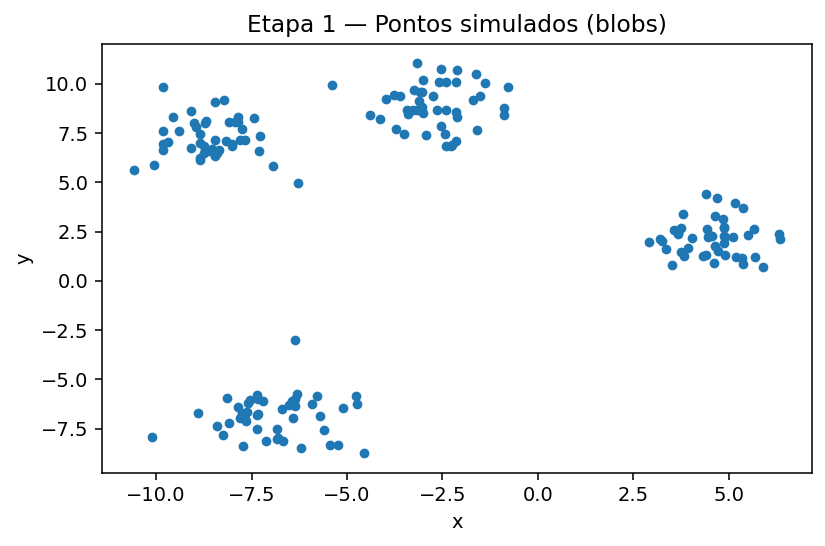

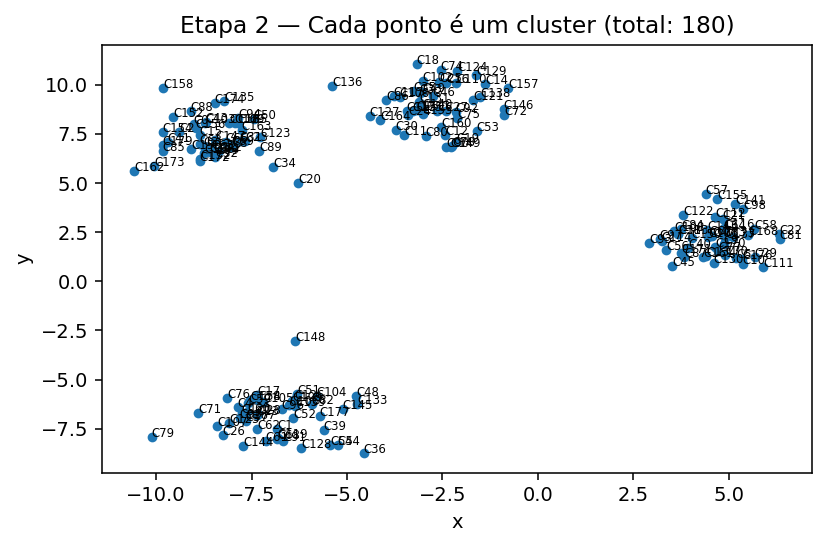

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
p0,inf,15.714063,0.574058,1.198233,14.493950,15.777358,6.417426,1.543229,1.559090,15.181795,16.076970,5.541709
p1,15.714063,inf,15.350280,14.520423,1.515002,14.871555,16.749310,14.206148,14.421804,15.036544,14.815539,15.356966
p2,0.574058,15.350280,inf,0.984911,14.104581,15.947246,6.852974,1.366181,1.587168,15.369613,16.238859,5.897241
p3,1.198233,14.520423,0.984911,inf,13.309174,15.061277,6.383669,0.381278,0.744655,14.499180,15.346341,5.280693
p4,14.493950,1.515002,14.104581,13.309174,inf,15.123870,15.979372,13.010041,13.260902,15.212374,15.105130,14.545429
p5,15.777358,14.871555,15.947246,15.061277,15.123870,inf,10.836353,14.720349,14.366637,0.778460,0.376437,10.726461
p6,6.417426,16.749310,6.852974,6.383669,15.979372,10.836353,inf,6.231659,5.680357,10.114236,11.191581,1.501258
p7,1.543229,14.206148,1.366181,0.381278,13.010041,14.720349,6.231659,inf,0.558301,14.164818,15.002648,5.070845
p8,1.559090,14.421804,1.587168,0.744655,13.260902,14.366637,5.680357,0.558301,inf,13.795091,14.656186,4.544443
p9,15.181795,15.036544,15.369613,14.499180,15.212374,0.778460,10.114236,14.164818,13.795091,inf,1.154810,10.053494


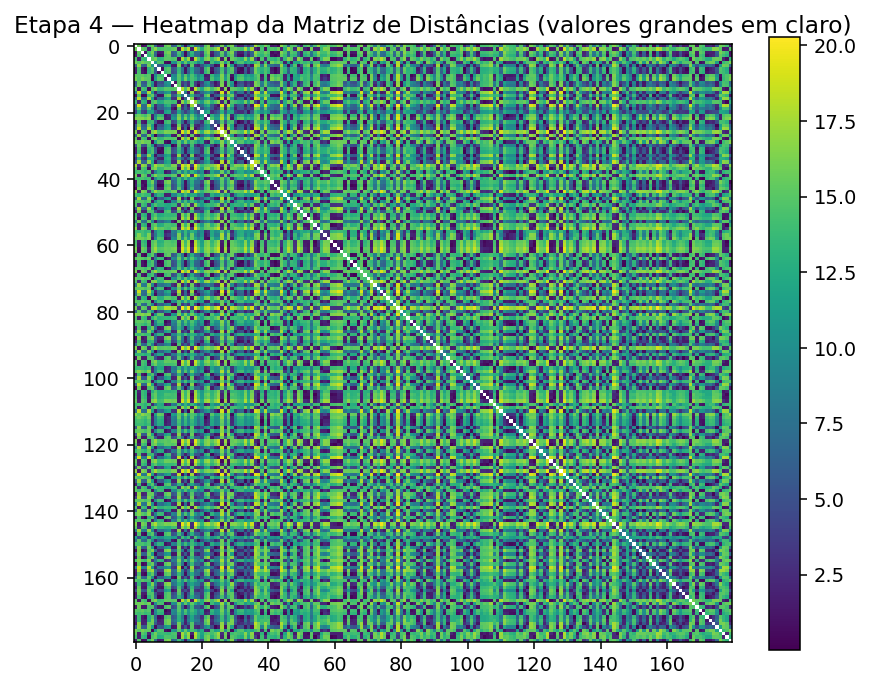

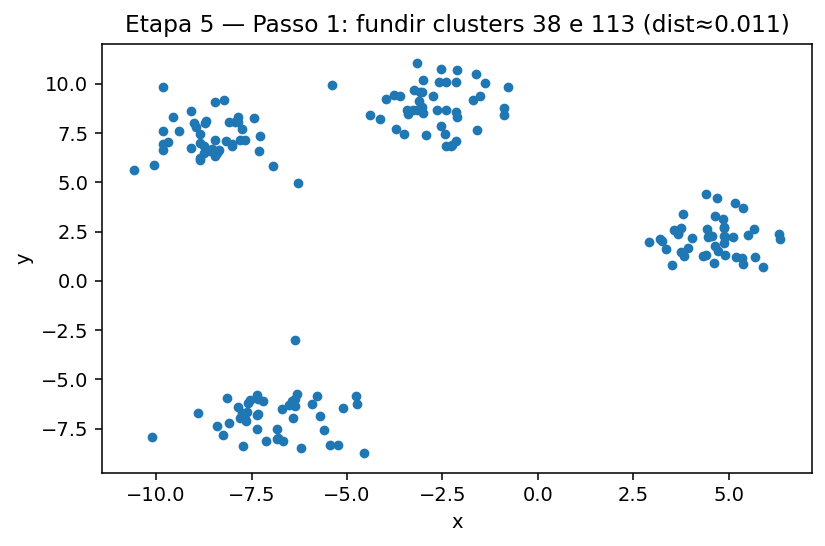

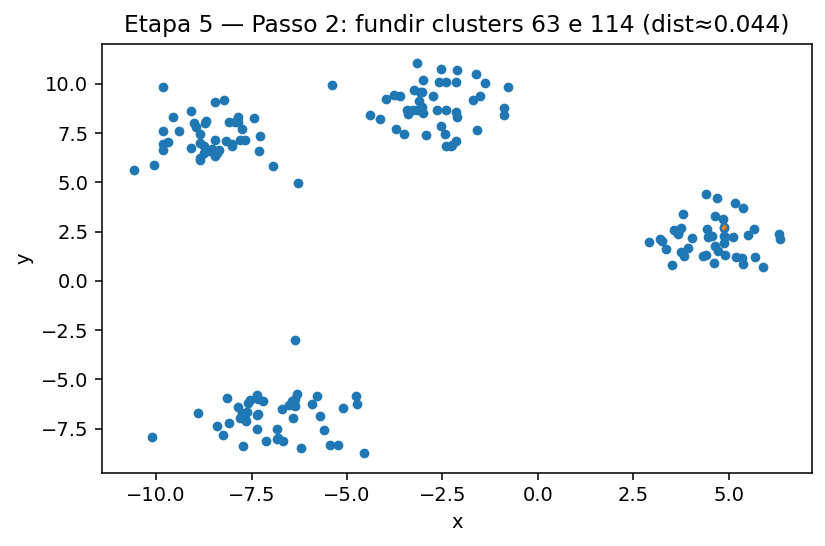

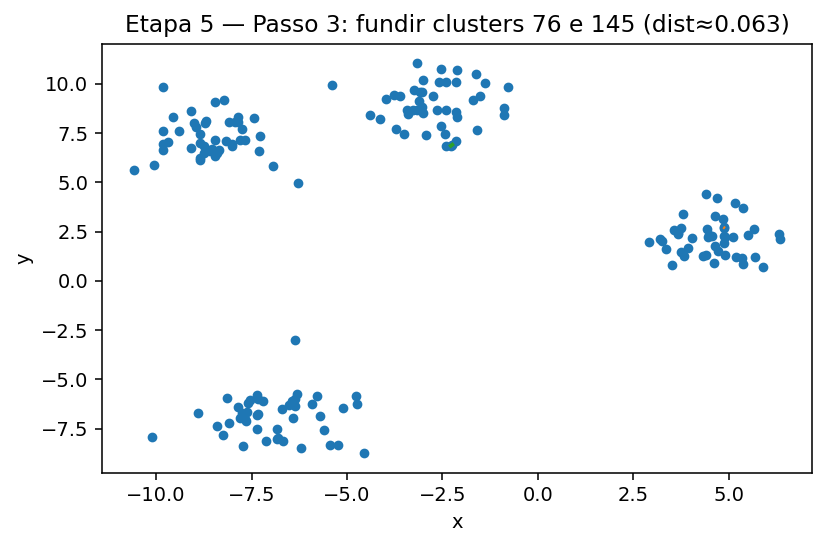

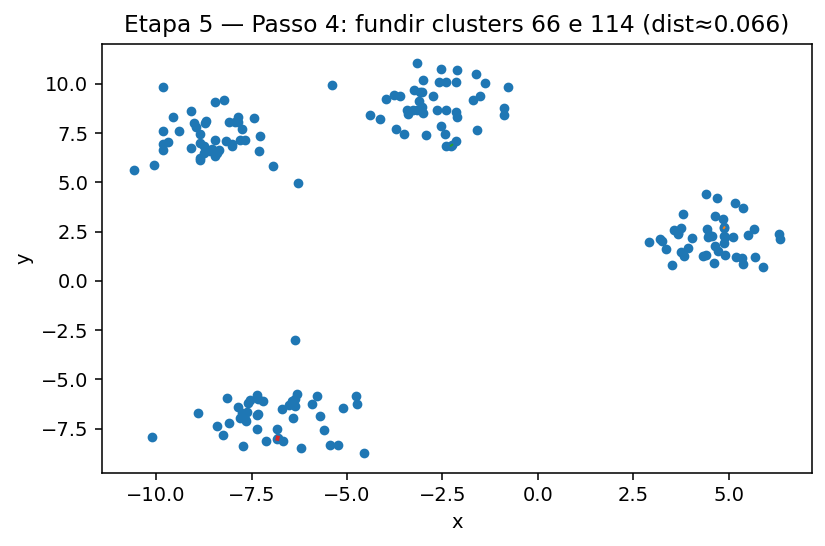

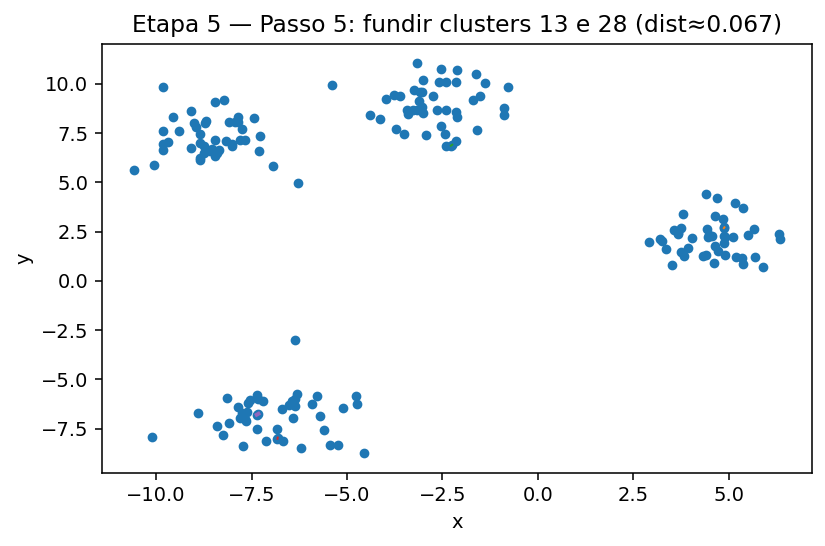

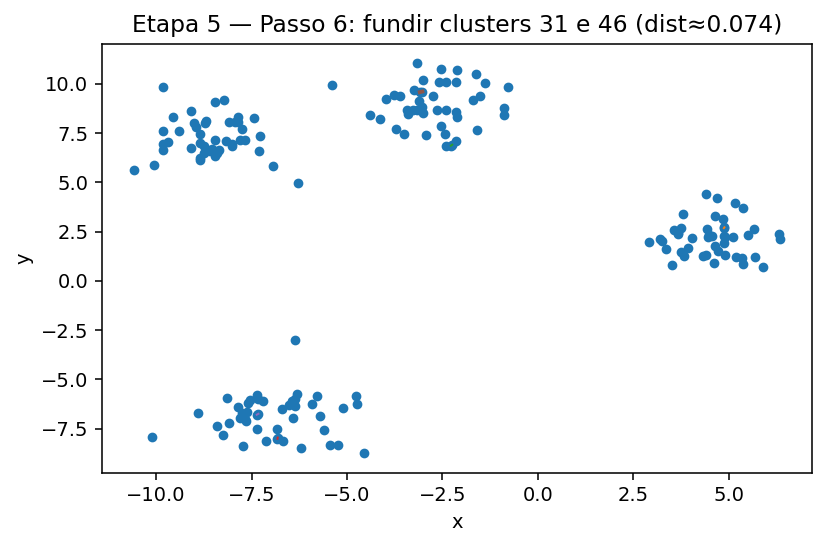

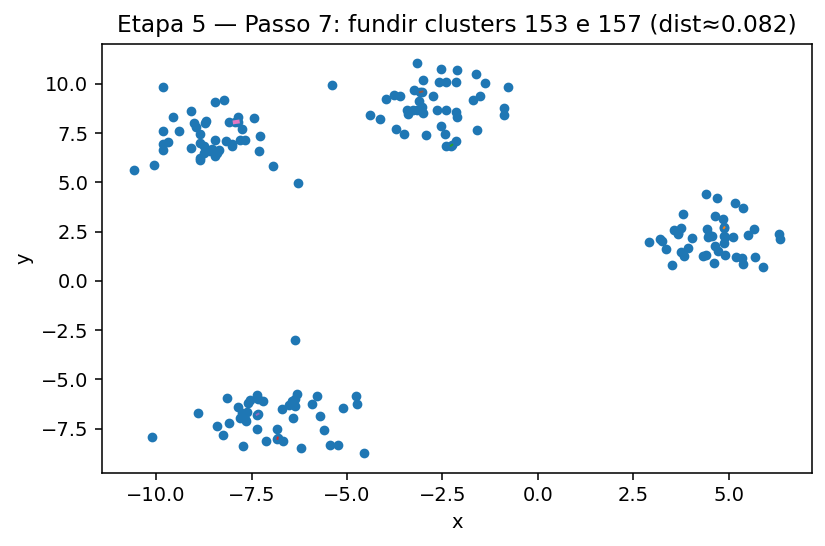

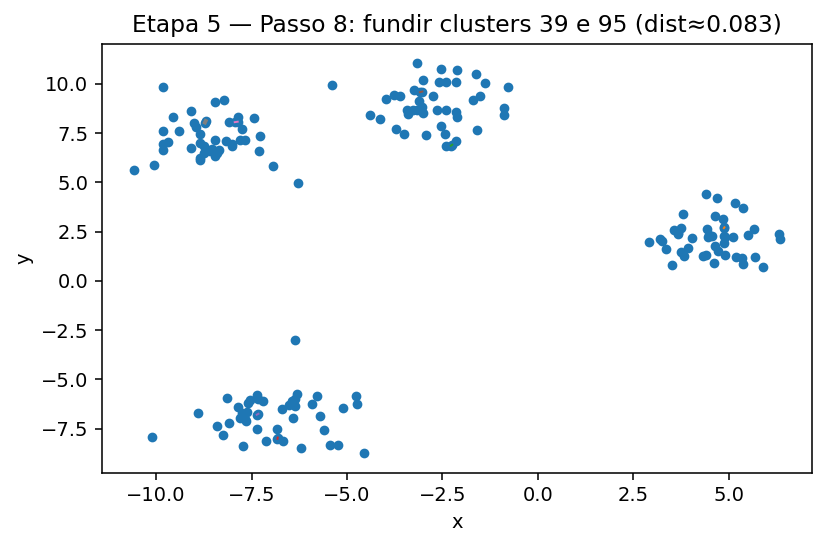

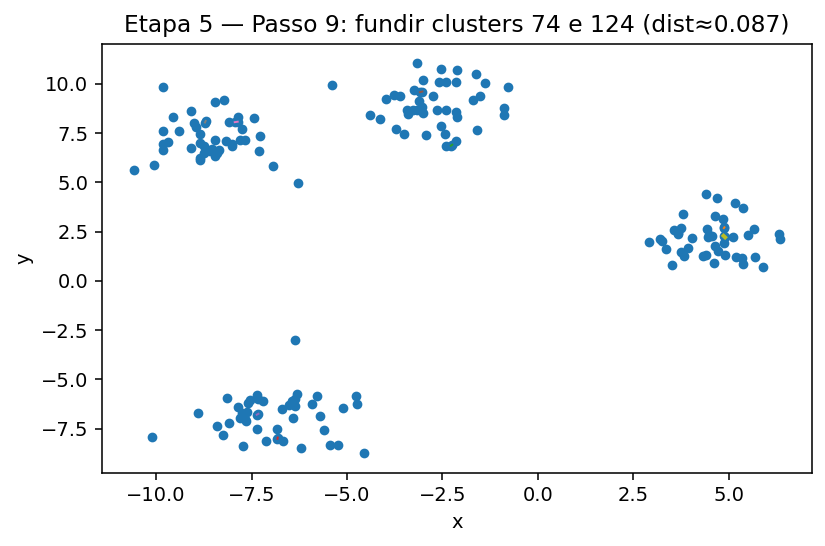

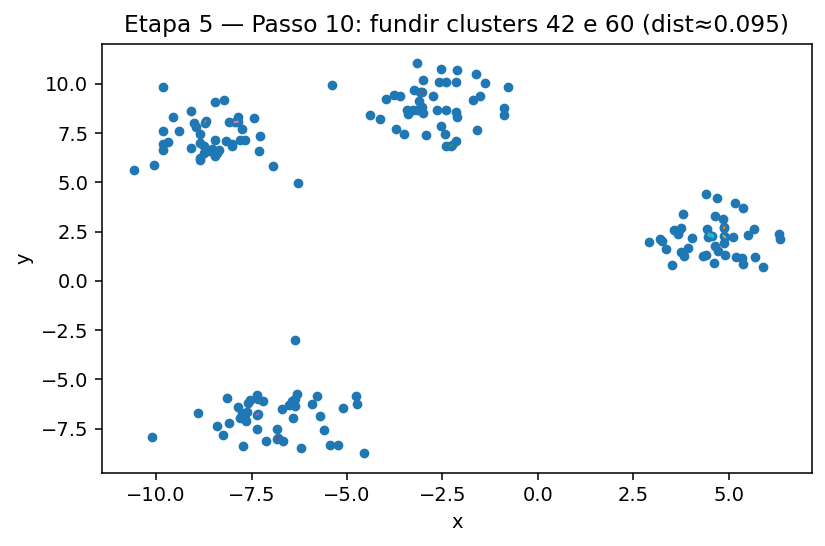

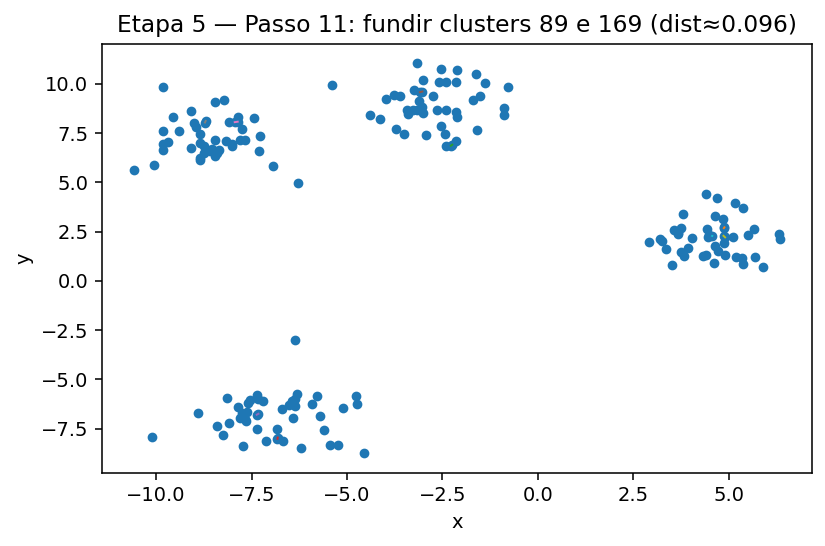

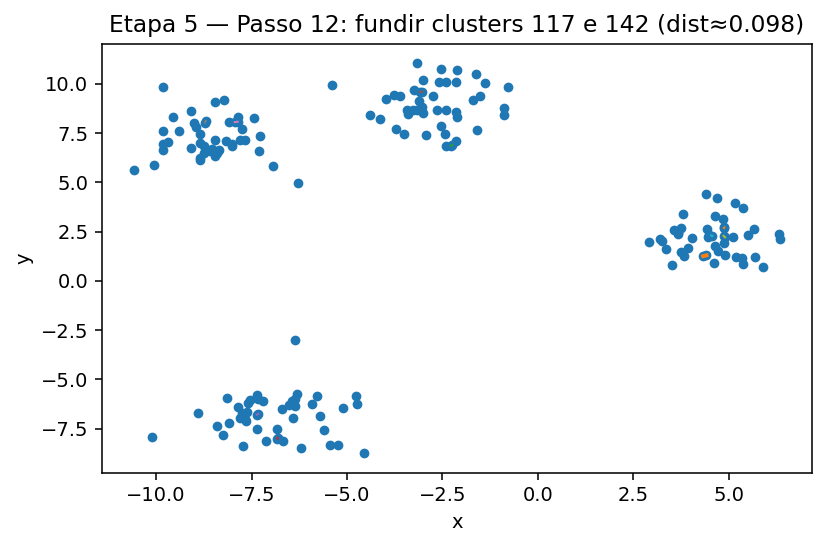

,passo,cluster_A_idx,cluster_B_idx,tamanho_A,tamanho_B,distancia_fusao,ponto_a,ponto_b
0,1,38,113,1,1,0.011119,38,113
1,2,63,114,1,1,0.043537,64,116
2,3,76,145,1,1,0.062686,78,149
3,4,66,114,1,1,0.065507,68,119
4,5,13,28,1,1,0.066646,13,28
5,6,31,46,1,1,0.073728,33,49
6,7,153,157,1,1,0.082006,165,169
7,8,39,95,1,1,0.082778,43,103
8,9,74,124,1,1,0.087137,83,137
9,10,42,60,1,1,0.094578,47,67


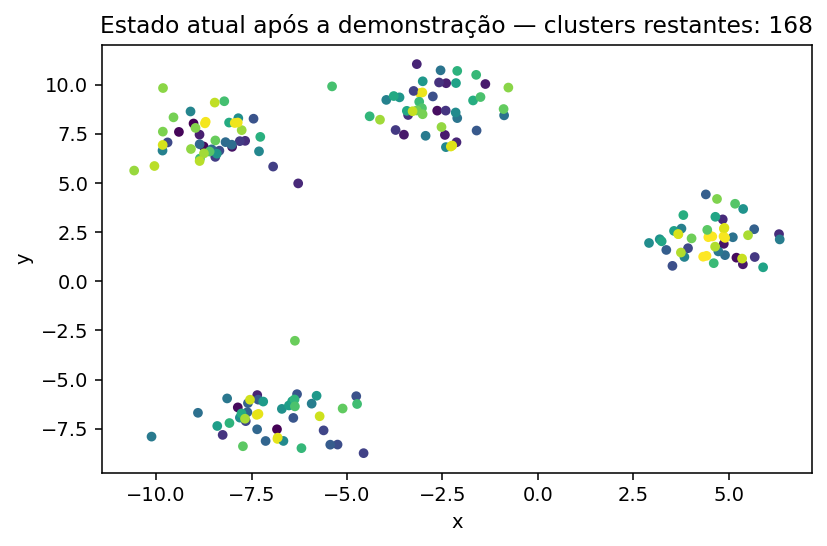

In [ ]:
# Simulando Questão 2  e outros testes
# SINGLE LINKAGE usando pontos simulados (make_blobs)
# Sequenciamento:
# 1) Gerar/plotar pontos
# 2) Cada ponto é um cluster
# 3) Calcular TODAS as distâncias (matriz D)
# 4) Inspecionar D (amostra + heatmap)
# 5) Executar fusões passo a passo (single linkage), ilustrando cada passo

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from typing import List, Set, Tuple
from sklearn.datasets import make_blobs

# ----------------------------
# Parâmetros
# ----------------------------
SEMENTE = 42
N_PONTOS = 180
N_CENTROS_VERDADE = 4
STD_CENTROS = [1.1, 0.9, 1.0, 1.2]  # pode ser float único ou lista

MAX_PASSOS = 12     # quantos passos ilustrar
K_ALVO = 5          # parar quando restarem K_ALVO clusters

# ----------------------------
# 1) Pontos simulados
# ----------------------------
X, y_true = make_blobs(
    n_samples=N_PONTOS,
    centers=N_CENTROS_VERDADE,
    cluster_std=STD_CENTROS if isinstance(STD_CENTROS, (list, tuple)) else STD_CENTROS,
    random_state=SEMENTE
)

plt.figure(figsize=(6, 4), dpi=140)
plt.scatter(X[:, 0], X[:, 1], s=16)
plt.title("Etapa 1 — Pontos simulados (blobs)")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()

# ----------------------------
# 2) Clusters iniciais
# ----------------------------
clusters: List[Set[int]] = [set([i]) for i in range(len(X))]

plt.figure(figsize=(6, 4), dpi=140)
plt.scatter(X[:, 0], X[:, 1], s=16)
for i, (x, y) in enumerate(X):
    plt.text(x, y, f"C{i}", fontsize=6)
plt.title(f"Etapa 2 — Cada ponto é um cluster (total: {len(clusters)})")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()

# ----------------------------
# 3) Matriz de distâncias
# ----------------------------
def matriz_distancias(X: np.ndarray) -> np.ndarray:
    """Matriz de distâncias Euclidianas (n x n), com diagonal = inf."""
    diff = X[:, None, :] - X[None, :, :]
    D = np.sqrt((diff ** 2).sum(axis=2))
    np.fill_diagonal(D, np.inf)
    return D

D = matriz_distancias(X)

# ----------------------------
# 4) Inspecionar D
# ----------------------------
k = min(12, len(X))
df_D = pd.DataFrame(D[:k, :k], index=[f"p{i}" for i in range(k)], columns=[f"p{j}" for j in range(k)])
display(df_D)  # Jupyter: exibe amostra 12x12

plt.figure(figsize=(6, 5), dpi=140)
plt.imshow(D, interpolation="nearest")
plt.title("Etapa 4 — Heatmap da Matriz de Distâncias (valores grandes em claro)")
plt.colorbar(); plt.tight_layout(); plt.show()

# ----------------------------
# 5) Single linkage — passo a passo
# ----------------------------
def par_minimo(Ca: Set[int], Cb: Set[int], D: np.ndarray) -> Tuple[int, int, float]:
    """Par (a,b) de pontos (um em Ca, outro em Cb) que minimiza a distância; retorna (a, b, dmin)."""
    ia = np.array(sorted(Ca))
    ib = np.array(sorted(Cb))
    sub = D[np.ix_(ia, ib)]
    pos = np.argmin(sub)
    ia_r, ib_c = divmod(int(pos), sub.shape[1])
    a = int(ia[ia_r]); b = int(ib[ib_c]); d = float(sub[ia_r, ib_c])
    return a, b, d

def escolher_par_minimo(clusters: List[Set[int]], D: np.ndarray) -> Tuple[int, int, float, Tuple[int, int]]:
    """Escolhe o par de clusters com menor distância single. Retorna (idx_i, idx_j, dmin, (a,b))."""
    melhor = np.inf
    idx_i, idx_j = -1, -1
    melhor_a, melhor_b = -1, -1
    for i, j in combinations(range(len(clusters)), 2):
        a, b, d = par_minimo(clusters[i], clusters[j], D)
        if d < melhor:
            melhor = d
            idx_i, idx_j = i, j
            melhor_a, melhor_b = a, b
    return idx_i, idx_j, melhor, (melhor_a, melhor_b)

historico = []        # registro das fusões
arestas_pts = []      # pares de pontos que motivaram cada fusão

passo = 0
while len(clusters) > K_ALVO and passo < MAX_PASSOS:
    idx_i, idx_j, dmin, (p_a, p_b) = escolher_par_minimo(clusters, D)

    # Visualização do passo atual: arestas antigas finas + atual mais espessa
    arestas_pts.append((p_a, p_b))
    plt.figure(figsize=(6, 4), dpi=140)
    plt.scatter(X[:, 0], X[:, 1], s=16)
    for (pa, pb) in arestas_pts[:-1]:
        xa, ya = X[pa]; xb, yb = X[pb]
        plt.plot([xa, xb], [ya, yb], linewidth=1)
    xa, ya = X[p_a]; xb, yb = X[p_b]
    plt.plot([xa, xb], [ya, yb], linewidth=2)
    plt.title(f"Etapa 5 — Passo {passo+1}: fundir clusters {idx_i} e {idx_j} (dist≈{dmin:.3f})")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout(); plt.show()

    # Registrar
    historico.append({
        "passo": passo + 1,
        "cluster_A_idx": idx_i,
        "cluster_B_idx": idx_j,
        "tamanho_A": len(clusters[idx_i]),
        "tamanho_B": len(clusters[idx_j]),
        "distancia_fusao": dmin,
        "ponto_a": p_a,
        "ponto_b": p_b
    })

    # Efetivar fusão (remover pelo índice MAIOR primeiro)
    Cnovo = clusters[idx_i] | clusters[idx_j]
    hi, hj = max(idx_i, idx_j), min(idx_i, idx_j)
    clusters.pop(hi)
    clusters.pop(hj)
    clusters.append(Cnovo)

    passo += 1

# Tabela dos passos exibidos
df_hist = pd.DataFrame(historico, columns=[
    "passo", "cluster_A_idx", "cluster_B_idx", "tamanho_A", "tamanho_B",
    "distancia_fusao", "ponto_a", "ponto_b"
])
display(df_hist)  # Jupyter: exibe a tabela

# Estado atual (rótulos por cluster restante)
rotulos = -np.ones(len(X), dtype=int)
for cid, s in enumerate(clusters):
    rotulos[list(s)] = cid

plt.figure(figsize=(6, 4), dpi=140)
plt.scatter(X[:, 0], X[:, 1], s=16, c=rotulos)
plt.title(f"Estado atual após a demonstração — clusters restantes: {len(clusters)}")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()


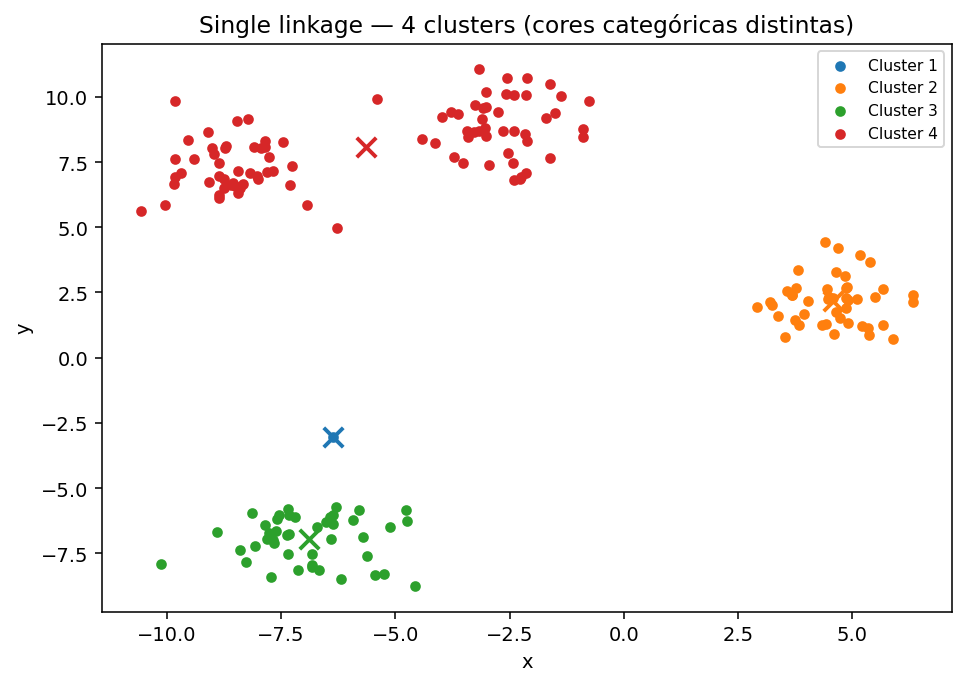

Tamanhos por cluster: [np.int64(1), np.int64(45), np.int64(44), np.int64(90)]


In [30]:
# -*- coding: utf-8 -*-
# Replot com CORES DISTINTAS por cluster (evita “dois grupos amarelos”).
# Usa paleta categórica (tab10) e legenda, marcando centróides.
# -> Supõe que você já tem X (pontos) e y_final (rótulos 0..K-1).
# -> Se y_final não existir, calcula com AgglomerativeClustering (single, K=4).

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Garante rótulos 0..K-1
try:
    labels = np.asarray(y_final).copy()
    K = int(len(np.unique(labels)))
except NameError:
    # Caso não exista y_final: calcula agora com single linkage para K=4
    from sklearn.cluster import AgglomerativeClustering
    K = 4
    labels = AgglomerativeClustering(linkage="single", metric="euclidean", n_clusters=K).fit_predict(X)

# Remapeia para 0..K-1 (ordem estável)
uniq = np.unique(labels)
mapa = {lab: i for i, lab in enumerate(uniq)}
labels_idx = np.array([mapa[l] for l in labels])
K = len(uniq)

# Paleta categórica com K cores distintas
categ = plt.get_cmap("tab10").colors  # 10 cores distintas
cmap = ListedColormap(categ[:K])

# Plot por cluster com cor fixa e centróide no MESMO tom
plt.figure(figsize=(7, 5), dpi=140)
for cid in range(K):
    pts = X[labels_idx == cid]
    plt.scatter(pts[:, 0], pts[:, 1], s=20, label=f"Cluster {cid+1}", color=cmap(cid))
    # centróide geométrico
    c = pts.mean(axis=0)
    plt.scatter(c[0], c[1], s=100, marker="x", linewidths=2, color=cmap(cid))

plt.title(f"Single linkage — {K} clusters (cores categóricas distintas)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc="best", fontsize=8, frameon=True)
plt.tight_layout(); plt.show()

# (Opcional) imprimir tamanhos p/ conferir
tamanhos = [np.sum(labels_idx == cid) for cid in range(K)]
print("Tamanhos por cluster:", tamanhos)


# Análise do resultado (single linkage)

No gráfico, dois aglomerados do topo viraram **um único cluster** (vermelho) e sobrou **um ponto isolado** (azul). Isso é típico do *single linkage*. Ele define a distância entre clusters como o **menor** par ponto-a-ponto:
$d_{\text{single}}(A,B)=\min_{x\in A,\,y\in B} d(x,y)$.


Se existe um par muito próximo — ou uma **cadeia** de pontos com pequenos saltos — dois grupos visualmente separados acabam **fundidos**. Foi o que ocorreu no topo: havia uma “ponte” curta ligando os dois aglomerados; como essa aresta não estava entre as mais longas na MST, o corte para $K=4$ **não** os separou.

O **ponto azul** ficou sozinho porque suas ligações são **mais longas** que várias outras dentro do conjunto; ao impor $K=4$, o corte da hierarquia preferiu manter o grande componente (com a ponte) e deixou o outlier como **singleton**.

Como evitar: usar **complete** ou **average linkage** (tendem a formar grupos mais compactos e quebram pontes), **cortar por um limiar de distância** em vez de fixar $K$, **restringir conexões** a um grafo k-NN, ou **tratar outliers** antes (ex.: DBSCAN). Em resumo: o resultado não é “erro” do algoritmo; é o comportamento esperado do single linkage quando há **pontes curtas** e **pontos isolados**.


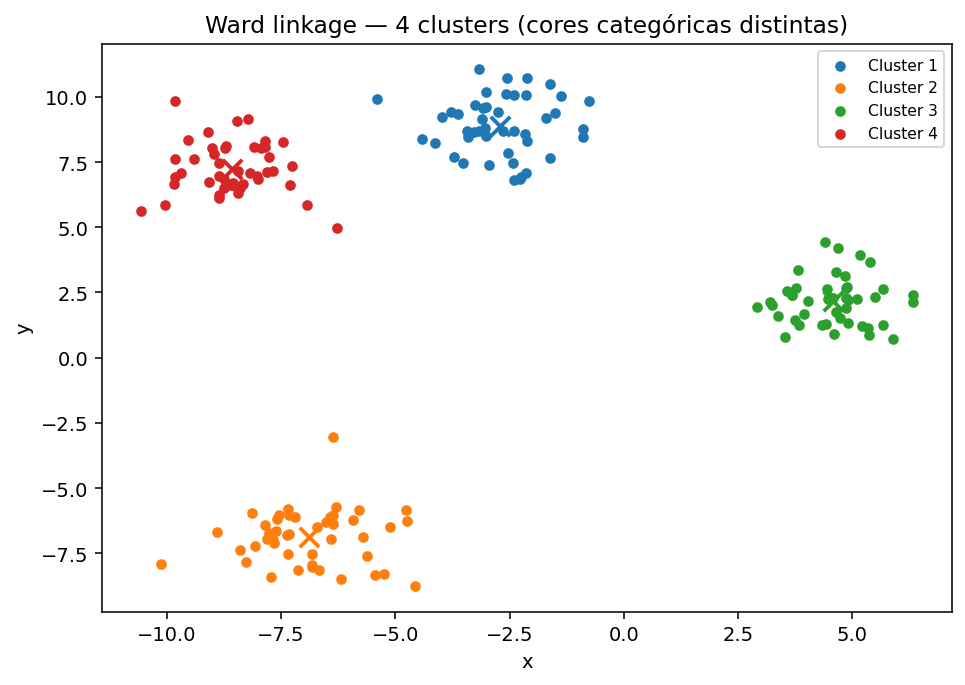

Tamanhos por cluster (Ward): [np.int64(45), np.int64(45), np.int64(45), np.int64(45)]


In [14]:
# -*- coding: utf-8 -*-
# Aplicando WARD linkage nos MESMOS pontos (X) já gerados com make_blobs.
# Mostra separação em 4 clusters, plota com cores categóricas distintas e marca centróides.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Garantir que X exista; se não existir, recria com os mesmos parâmetros do exemplo inicial
try:
    _ = X.shape
except NameError:
    from sklearn.datasets import make_blobs
    SEMENTE = 42
    N_PONTOS = 180
    N_CENTROS_VERDADE = 4
    STD_CENTROS = [1.1, 0.9, 1.0, 1.2]
    X, _ = make_blobs(
        n_samples=N_PONTOS,
        centers=N_CENTROS_VERDADE,
        cluster_std=STD_CENTROS,
        random_state=SEMENTE
    )

# 2) Ajustar AgglomerativeClustering com linkage="ward" (métrica Euclidiana)
from sklearn.cluster import AgglomerativeClustering
K = 4
y_ward = AgglomerativeClustering(linkage="ward", n_clusters=K).fit_predict(X)

# 3) Remapear rótulos para 0..K-1 (ordem estável)
uniq = np.unique(y_ward)
mapa = {lab: i for i, lab in enumerate(uniq)}
rotulos = np.array([mapa[l] for l in y_ward])

# 4) Paleta categórica e plot com centróides no mesmo tom
categ = plt.get_cmap("tab10").colors  # 10 cores distintas
cmap = ListedColormap(categ[:K])

plt.figure(figsize=(7, 5), dpi=140)
for cid in range(K):
    pts = X[rotulos == cid]
    plt.scatter(pts[:, 0], pts[:, 1], s=20, label=f"Cluster {cid+1}", color=cmap(cid))
    centroide = pts.mean(axis=0)
    plt.scatter(centroide[0], centroide[1], s=100, marker="x", linewidths=2, color=cmap(cid))

plt.title(f"Ward linkage — {K} clusters (cores categóricas distintas)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc="best", fontsize=8, frameon=True)
plt.tight_layout(); plt.show()

# 5) Tamanhos por cluster (checagem rápida)
tamanhos = [np.sum(rotulos == cid) for cid in range(K)]
print("Tamanhos por cluster (Ward):", tamanhos)


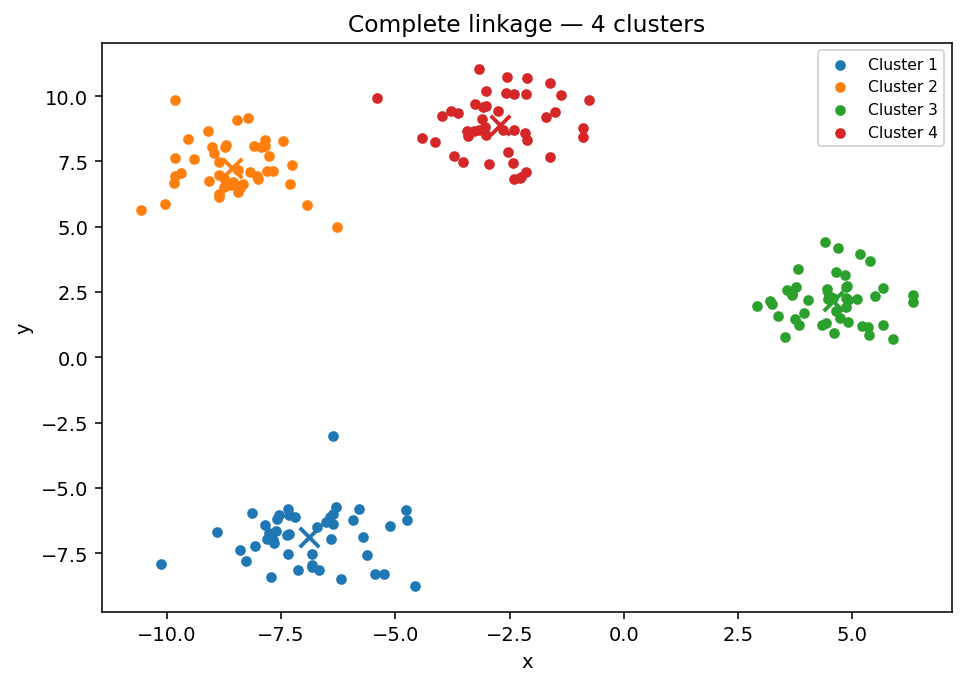

Tamanhos por cluster (Complete): [np.int64(45), np.int64(45), np.int64(45), np.int64(45)]


In [17]:
# -*- coding: utf-8 -*-
# COMPLETE LINKAGE nos MESMOS pontos (X) da simulação anterior.
# Gera rótulos com K=4, plota clusters e marca centróides.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Garantir que X exista; se não existir, recria com os mesmos parâmetros do exemplo
try:
    _ = X.shape
except NameError:
    from sklearn.datasets import make_blobs
    SEMENTE = 42
    N_PONTOS = 180
    N_CENTROS_VERDADE = 4
    STD_CENTROS = [1.1, 0.9, 1.0, 1.2]
    X, _ = make_blobs(
        n_samples=N_PONTOS,
        centers=N_CENTROS_VERDADE,
        cluster_std=STD_CENTROS,
        random_state=SEMENTE
    )

# 2) Ajustar AgglomerativeClustering com linkage="complete" (Euclidiana)
from sklearn.cluster import AgglomerativeClustering
K = 4
y_complete = AgglomerativeClustering(
    linkage="complete", metric="euclidean", n_clusters=K
).fit_predict(X)

# 3) Remapear rótulos para 0..K-1 (ordem estável)
uniq = np.unique(y_complete)
mapa = {lab: i for i, lab in enumerate(uniq)}
rotulos = np.array([mapa[l] for l in y_complete])

# 4) Paleta categórica e plot com centróides
categ = plt.get_cmap("tab10").colors  # 10 cores categóricas
cmap = ListedColormap(categ[:K])

plt.figure(figsize=(7, 5), dpi=140)
for cid in range(K):
    pts = X[rotulos == cid]
    plt.scatter(pts[:, 0], pts[:, 1], s=20, label=f"Cluster {cid+1}", color=cmap(cid))
    c = pts.mean(axis=0)
    plt.scatter(c[0], c[1], s=100, marker="x", linewidths=2, color=cmap(cid))

plt.title(f"Complete linkage — {K} clusters")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc="best", fontsize=8, frameon=True)
plt.tight_layout(); plt.show()

# 5) Tamanhos por cluster (checagem)
tamanhos = [np.sum(rotulos == cid) for cid in range(K)]
print("Tamanhos por cluster (Complete):", tamanhos)
